In [1]:
import os

import pandas as pd
import matplotlib.figure
import matplotlib.pyplot as plt
import numpy as np
import yaml
import seaborn as sns

FIGURES_DIR = "figures"

# Apply the default theme
sns.set_theme()

# Ensure that the figures directory exists
if not os.path.exists(FIGURES_DIR):
    os.mkdir(FIGURES_DIR)
    

def save_figure(figure: matplotlib.figure.Figure, filename: str) -> None:
    figure.savefig(os.path.join(FIGURES_DIR, filename))

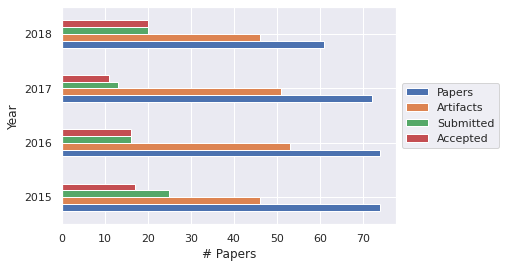

In [2]:
with open('data/aec.csv') as f:
    aecs = pd.read_csv(f).set_index(['year'])
    aecs = aecs.rename(columns={
        "papers": "Papers",
        "artifacts": "Artifacts",
        "submitted": "Submitted",
        "accepted": "Accepted",
    })
    del aecs['conference']
    
ax = aecs.plot(kind='barh')
ax.set_xlabel('# Papers')
ax.set_ylabel('Year')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.get_figure().savefig(
    os.path.join(FIGURES_DIR, "aec-submission-acceptance.pdf"),
    bbox_extra_artists=(legend,),
    bbox_inches="tight",
)

Below, we analyze the availability of artifacts.

In [3]:
with open('data/publication-analysis.yml', 'r') as f:
    publications = yaml.safe_load(f)
    
for pub in publications:
    pub['num_artifact_links'] = len(pub['artifact-links'])
    pub['num_artifact_links_alive'] = sum(1 for link in pub['artifact-links'] if link['is-alive'])
    pub['num_artifact_links_dead'] = pub['num_artifact_links'] - pub['num_artifact_links_alive']
    
papers = pd.DataFrame.from_dict(publications)
papers['has_artifact'] = papers['num_artifact_links'] > 0
papers['has_no_artifact'] = papers['num_artifact_links'] == 0

def paper_is_alive(row) -> bool:
    if not row['has_artifact']:
        return np.NaN
    return row['num_artifact_links_dead'] == 0

def paper_is_dead(row) -> bool:
    if not row['has_artifact']:
        return np.NaN
    return row['num_artifact_links_dead'] > 0

papers['is_alive'] = papers.apply(paper_is_alive, axis=1)
papers['is_dead'] = papers.apply(paper_is_dead, axis=1)

Below is a graphical representation of artifact prevalence at ASE, FSE, ICSE, and EMSE between 2014 and 2018, inclusive.

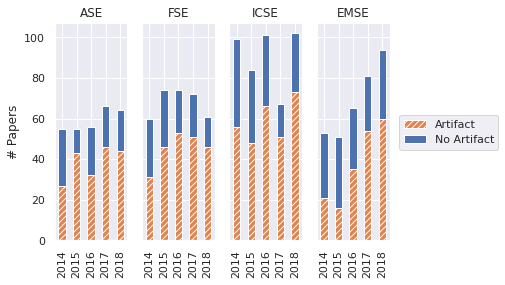

In [4]:
my_colors = ['#dd8452', '#4c72b0']

venues = ['ASE', 'FSE', 'ICSE', 'EMSE']
fig, axes = plt.subplots(nrows=1, ncols=len(venues), sharey=True, sharex=True)
for index, venue in enumerate(venues):
    df = papers[papers['venue'] == venue][['venue', 'year', 'has_artifact', 'has_no_artifact']]
    df = df.groupby(['year']).agg(
        {'has_artifact': 'sum',
         'has_no_artifact': 'sum',
        })
    df.rename(columns={'has_artifact': 'Artifact'}, inplace=True)
    df.rename(columns={'has_no_artifact': 'No Artifact'}, inplace=True)
    ax = df.plot(title=venue, kind='bar', stacked=True, ax=axes[index], legend=False, ylabel='# Papers', xlabel='', color=my_colors)
    
    for bar in ax.patches[:5]:
        bar.set_hatch('////')
    
labels = fig.axes[-1].get_legend_handles_labels()[1]
legend = fig.legend(labels, loc='center left', bbox_to_anchor=(0.91, 0.5))
ax.get_figure().savefig(
    os.path.join(FIGURES_DIR, "artifact-prevalence.pdf"),
    bbox_extra_artists=(legend,),
    bbox_inches="tight",
)

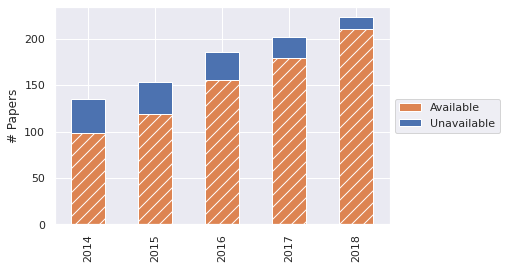

In [8]:
my_colors = ['#dd8452', '#4c72b0']

df = papers[['year', 'is_alive', 'is_dead']]
df = df.groupby(['year']).agg(
        {'is_alive': 'sum',
         'is_dead': 'sum',
        })
df.rename(columns={'is_dead': 'Unavailable'}, inplace=True)
df.rename(columns={'is_alive': 'Available'}, inplace=True)
ax = df.plot(kind='bar', stacked=True, ylabel='# Papers', xlabel='', color=my_colors)
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

for bar in ax.patches[:5]:
    bar.set_hatch('//')

ax.get_figure().savefig(
    os.path.join(FIGURES_DIR, "availability.pdf"),
    bbox_extra_artists=(legend,),
    bbox_inches="tight",
)

## Author Survey Demographics

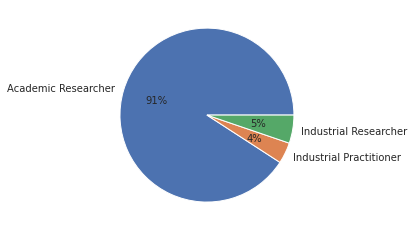

In [19]:
demographic_role = pd.DataFrame(
    [
        ['Academic Researcher', 139],
        ['Industrial Practitioner', 6],
        ['Industrial Researcher', 8],
    ],
    columns=['Role', 'Frequency'],
)
demographic_role.set_index('Role', inplace=True)


ax = demographic_role.plot(kind='pie', y='Frequency', legend=False, ylabel='', autopct='%1.0f%%', fontsize=10)
save_figure(ax.get_figure(), "demographic-role.pdf")